# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».  

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из ранее выполненного проекта). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.  

Нужно построить модель с максимально большим значением accuracy. Доля правильных ответов должна быть не ниже 0.75 (на тестовой выборке).

**Задачи:**
- разделить данные на тренировочную, валидационную и тестовую выборки
- выбрать несколько моделей и оптимизировать их гиперпараметры
- выбрать лучшую модель и проверить её качество на тестовой выборке
- проверить вменяемость модели

**Описание данных:**
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Загрузка и обзор данных

**Загрузка используемых в исследовании модулей**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix

**Загрузка данных**

In [10]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

Рассмотрим типы данных и количество записей в столбцах:

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Типы данных в целом соответствуют необходимым.  
В случае большего числа записей число звонков и сообщений следовало бы перевести в целочисленных формат, а для индикатора тарифного плана можно было бы использовать логический тип данных. Такие меры позволили бы уменьшить использование памяти. Однако при текущем небольшом количестве записей дополнительные действия можно не предпринимать.  

По заданию данные предобработаны, отсутствие пропусков это косвенно подтверждает. Проверим отсутствие дубликатов:

In [4]:
data.duplicated().sum()

0

Дубликаты в таблице отсутствуют.  
Рассмотрим описательные статистики по столбцам:

In [5]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Разброс значений умеренный. Близость средних и медианных значений по всем столбцам (кроме индикатора тарифа) свидетельстсвует о симметричности распределения значений.  
Стоит обратить внимание на то, что среднее значение индикатора тарифного плана меньше 0,5, т.е. *пользователи тарифных планов представлены неравномерно* , это должно быть учтено при выделении обучающей, валидационной и тестовой выборок.  
Рассмотрим гистрограммы распределений признаков пользователей:

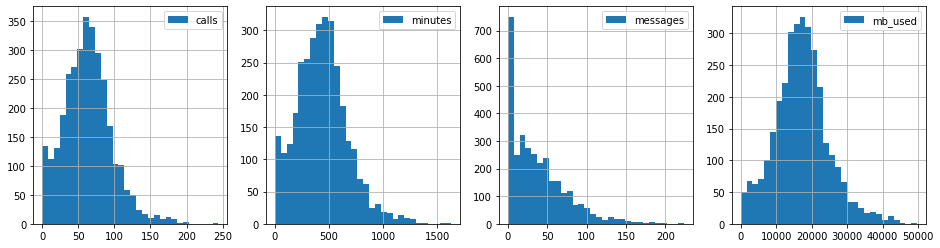

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(16,4))
ax_i = 0
for col in data.columns[:-1]:
    data[col].hist(bins=30, ax=ax[ax_i], legend=True)
    ax_i += 1

Выделяются следующие особенности:
- большие доли нулевых значений звонков, минут и особенно сообщений;
- длинные "хвосты" в области больших значений для тех же параметров.  

Такие особенности вполне согласуются с поведением реальных пользователей, поэтому их следует оставить.

## Разделение данных на выборки

Для тестовой и валидационной выборок выделим по 15 % данных.

In [16]:
#Количество записей для отбора в валидационный и тестовый наборы:
data

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Выбор получим как срезу из исходной таблицы по индексам. Чтобы выборки были случайными перемешаем список индексов при помощи функции `shuffle` модуля `numpy.random`:

In [18]:
train_valid, data_test = train_test_split(data, test_size=0.15, stratify=data['is_ultra'])
data_train, data_valid = train_test_split(train_valid, test_size=0.15, stratify=train_valid['is_ultra'])
list_of_data = [data_train, data_valid, data_test]

In [9]:
#Тренировочную выборку получим как срез по первым 2250 индексам из списка случайно выбранным индексам:
data_train = data.iloc[index_list[:-2*len_for_test]]
#Тренировочную выборку получим как срез по индексам с 2251 по 2732 из списка случайно выбранных индексов:
data_valid = data.iloc[index_list[-2*len_for_test:-1*len_for_test]]
#Тестовую выборку получим как срез по последним 482 индекам из списка случайно выбранных индексов:
data_test = data.iloc[index_list[-1*len_for_test:]]
#Для удобства поместим все выборки в один список:
list_of_data = [data_train, data_valid, data_test]

Проверим отсутствие пересечений у наборов данных:

In [10]:
display((set(data_valid.index) & set(data_train.index), set(data_test.index) & set(data_train.index)))

(set(), set())

Полученные выборки не пересекаются. Проверим равноверность распределения пользователей разных тарифов по выборкам:

In [19]:
for table in list_of_data:
    print(table.is_ultra.mean())

0.3063334769495907
0.3073170731707317
0.3064182194616977


Доли пользователей тарифного плана `ultra` для всех выборок близки к доле по исходной выборе.  

Разделим данные на таблицы с признаками и таблицы со значениями целевой переменной:

In [20]:
list_of_features = [table[table.columns[:-1]] for table in list_of_data]
list_of_target = [table['is_ultra'] for table in list_of_data]

Поскольку признаки имеют разный разброс значений (и разные абсолютные значения) для корректного применения регуляризации в линейных моделях значения признаков следует сделать более единообразными. Приведем значения дисперии параметров клиентов к 1 при помощи `StandardScaler` из пакета `sklearn`:

In [21]:
scaler = StandardScaler()
scaler.fit(list_of_features[0])
list_of_features = [scaler.transform(table) for table in list_of_features]

В дальнейшем следует учитывать что итоговая модель работает на стандартизированных данных, причем значения дисперсий получены на тренировочной выборке.

## Исследование моделей

Рассмотрим простейшую модель логистической регрессии. В качестве варьируемых гиперпараметров возьмем способ регуляризации:

In [22]:
for reg in ['none', 'l1', 'l2']:
    linear_model = LogisticRegression(penalty=reg, random_state=123, solver='saga')
    linear_model.fit(list_of_features[0], list_of_target[0])
    accuracy = linear_model.score(list_of_features[1], list_of_target[1])
    print(f"Для регуляризации {reg} доля верных ответов (accuracy) - {accuracy:0.3f}")

Для регуляризации none доля верных ответов (accuracy) - 0.727
Для регуляризации l1 доля верных ответов (accuracy) - 0.727
Для регуляризации l2 доля верных ответов (accuracy) - 0.727


Все три модели независимо от типа регуляризации показывают долю верных ответов близкую к заданной по условию (75%). Однако для уверенности найдем модель с более высоким качеством предсказаний.  
  
Рассмотрим более сложную модель - дерево решений. В качестве варьируемых параметров возьмем критерий разделения, максимальную глубину дерева, минимальное число объектов в листах, минимальное число объекто для деления, максимальное число признаков:

In [23]:
best_accuracy = 0
best_model = None
#Перебор параметров сделаем при помощи вложенных циклов:
for max_depth in range(1, 40, 2):
    for min_samples_split in range(2, 10):
        for max_features in [None, 'sqrt', 'log2']:
            model = DecisionTreeClassifier(max_depth=max_depth,
                                           min_samples_split=min_samples_split,
                                           max_features=max_features, 
                                           random_state=123)
            model.fit(list_of_features[0], list_of_target[0])
            accuracy = model.score(list_of_features[1], list_of_target[1])

            #Сохраним лучшую модель и accuracy:            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                
print(f"Лучшая доля верных ответов: {best_accuracy:0.3f}")
best_parameters_tree = best_model.get_params()
print("Параметры лучшей модели:")
best_parameters_tree

Лучшая доля верных ответов: 0.817
Параметры лучшей модели:


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 123,
 'splitter': 'best'}

Модель на основе дерева решений показывают значительно более высокую долю верных ответов, по сравнению с логистической регрессией.  
Высокая доля правильных ответов достигается в значительной степени за счет большой глубины дерева.  
В качестве более сложной модели рассмотрим случайных лес деревьев решений.  
Обучение случайного леса занимает больше времени чем обучение однорого дерева. Чтобы излишне не усложнять процесс оптимизровать будем только гиперпараметры n_estimators, max_depth:

In [16]:
best_accuracy = 0
best_model = None

#Перебор параметров сделаем при помощи вложенных циклов:
for n_estimators in range(20, 120, 20):
    for max_depth in range(2, 20, 2):
        model = RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       random_state=123)
        model.fit(list_of_features[0], list_of_target[0])
        accuracy = model.score(list_of_features[1], list_of_target[1])
        
        #Сохраним лучшую модель и accuracy:  
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

print(f"Лучшая доля верных ответов: {best_accuracy:0.3f}")
best_parameters_forest = best_model.get_params()
print("Параметры лучшей модели:")
best_parameters_forest

Лучшая доля верных ответов: 0.817
Параметры лучшей модели:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 40,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

Использование случайного леса позволило дополнительно повысить долю верных ответов (на 1%). Максимальное качество модели было достигнуто за счет увеличения числа деревьев в лесу. Оптимальное число деревьев в лесу чувствительно к разбиению данных на выборки. В данном исследовании при увеличении числа деревьев свыше 100 скорость роста качества модели снижается.  
Учитывая близкое качество двух последних моделей, сравним время их обучения:

In [17]:
model = DecisionTreeClassifier(**best_parameters_tree)
%timeit model.fit(list_of_features[0], list_of_target[0])

4.34 ms ± 76 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
model = RandomForestClassifier(**best_parameters_forest)
forest_time = %timeit model.fit(list_of_features[0], list_of_target[0])

158 ms ± 4.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


В данном исследовании время обучения леса из $n$ деревьев приблизительно в  $0,75 - 0,8 \cdot n$ раз больше времени обучения отдельного дерева.  
Лучшей моделью из сравниваемых будет **случайный лес деревьев решений**, однако в случае большего объема данных и большего числа признаков обучение такой модели может оказаться неприемлемо сложным.

## Проверка модели на тестовой выборке

Сравним полученную на валидационной выборке долю верных ответов со значением на тестовой выборке:

In [19]:
accuracy_test = model.score(list_of_features[2], list_of_target[2])
print(f"Доля верных ответов лучшей модели на тестовой выборке: {accuracy_test:0.3f}")

Доля верных ответов лучшей модели на тестовой выборке: 0.803


Модель дает предсказания высокого качетсва на тестовой выборке. Полученное значение несколько ниже значения на валидационной выборке, однако отличие не слишком большое, таким образом модель не является переобученной.  
Рассмотрим также покрытие положительных ответов на тестовой выборке (метрику `recall`):

In [20]:
recall_score_test = recall_score(model.predict(list_of_features[2]), list_of_target[2])
f1_score_test = f1_score(model.predict(list_of_features[2]), list_of_target[2])

print(f"Покрытие положительных ответов на тестовой выборке: {recall_score_test:0.3f}")
print(f"F1-метрика для тестовой выборки: {f1_score_test:0.3f}")
print(f"Confusion matrix для тестовой выборки:")
confusion_matrix(model.predict(list_of_features[2]), list_of_target[2])

Покрытие положительных ответов на тестовой выборке: 0.736
F1-метрика для тестовой выборки: 0.622
Confusion matrix для тестовой выборки:


array([[309,  67],
       [ 28,  78]])

Модель обладает высоким качетсвом также по метрике `recall`. Несколько худший результат получается для F1-метрики.  
Наблюдаемое различие может быть объяснено различием долей положительных ответов (пользователей тарифа `ultra`) в тестовой и валидационной выборках.  
Модель характеризуется довольно большой долей ложно-отрицательных ответов (ответ is_ultra = 0, когда в действительности is_ultra = 1).  
В зависимости от бизнес-задач это быть проблемой и требовать доработки модели.  
Например при предсказании клиентов, которые хотят сменить тариф на более дешевый (`smart` вместо `ultra`) такие ложно-отрицательные ответы потребуют дополнительной и не нужной работы с клиентами.

## Проверка модели на вменяемость

Вменяемая модель должна давать точность предказаний лучше, чем при случайном угадывании. Поскольку данные не сбалансированные, хорошую долю правильных ответов будет давать модель в которой все значения `is_ultra` равны 0, независимо от остальных признаков:

In [21]:
random_test_target = np.zeros(len(list_of_target[2]))

Проверим случайное угадывание и вменяемость обученной модели:

In [22]:
accuracy_score_random_test = accuracy_score(list_of_target[2]>1, list_of_target[2])
print(f"Доля верных ответов при случайном угадывании: {accuracy_score_random_test:0.2f}")

if accuracy_test > accuracy_score_random_test:
    print("Доля верных ответов для обученой модели выше случайной - модель адекватна")
else:
    print("Доля верных ответов для обученой модели ниже или равна случайной - модель не адекватна")

Доля верных ответов при случайном угадывании: 0.70
Доля верных ответов для обученой модели выше случайной - модель адекватна


## Выводы

Предоставленные данные имеют достаточно высокое качество и не требует дополнительной обработки.

Выделяются следующие особенности:
- большие доли нулевых значений звонков, минут и особенно сообщений;
- длинные "хвосты" в области больших значений для тех же параметров.
Такие особенности вполне согласуются с поведением реальных пользователей, поэтому должны быть оставлены без изменений.

Распределение клиентов по индикатору `is_ultra` несбалансированно - большинство клиентов (~70%) не являются пользователями тарифа Ultra, что несколько снижает качество получаемых моделей.

Сравнение моделей логистической регрессии, дерева решений и случайного леса показало что наилучшее качество предсказаний дает модель случайного леса.

Полученная модель является адекватной и даёт лучший результат (accuracy ~80% на тестовой выборке) чем константная модель, всегда предсказывающая нулевое значение `is_ultra` (accuracy ~70 %). При этом модель даёт достаточно большое количество ложно-отрицательных предсказаний (почти 50 % от всех `is_ultra` = 1). Таким образом, для использования на практике требуется доработка модели, например обучение на более сбалансированной выборке.  

При соответствующей доработке модель может быть использована для определения клиентов, которые могут перейти с более дорого тарифа `Ultra` на более дешевые тарифы, для работы с такими клиентами.